# 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from environment import stock
import time

tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# 可视化

In [2]:
def show_total_reward(rewards):    
    plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
    plt.figure(figsize=(8, 4))
    plt.plot(rewards)
    plt.xlabel("回合", fontsize=14)
    plt.ylabel("奖励总和", fontsize=14)
    plt.grid(True)
    plt.title("训练得分情况")

# 网络

In [3]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

n_outputs = 5  # == env.action_space.n

model = keras.models.Sequential(
    [
        keras.layers.Conv2D(
            16, 6, activation="relu", padding="same", input_shape=[575, 800, 3]
        ),
        keras.layers.MaxPool2D(2),  # 池化层，大小2，在每个维度除以2(等于步幅)
        keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        # 重复滤波、池化，每池化一次，滤波器数理加倍，因为池化后空间维度除以2，不用担心参数爆炸增长
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(2),
        keras.layers.Flatten(),  # 把图像转为一维数组，接上全连接网络
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),  # 每次drop一半神经元防止过拟合
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(n_outputs),  # 输出五个动作价值
    ]
)

# 贪婪策略

In [4]:
def epsilon_greedy_policy(model, state, epsilon=0):  # epsilon设定贪婪度，越高则越选择Q值高的动作
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # 在1-epsilon概率下随机选择动作
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[
            0
        ]  # 出来之后应该有两个维度，去掉最外层方便后续
        return Q_values.argmax()  # DQN给出的Q值最高的动作索引

# 创建经验表

In [5]:
from collections import deque

# 重播缓存
replay_buffer = deque(maxlen=4000)  #### 长度3000的双端列表，性质类似list但是处理复杂度更低


# 经验采样

In [6]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    # 0~n的均匀分布，抽取大小为batch_size的随机数组
    batch = [replay_buffer[index] for index in indices]  # 按随机序号抽取缓存中的经验
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]  # [states, actions, rewards, next_states, dones] 每个元素是一个ndarray数组


# 运行单步

In [7]:
def play_one_step(model, env, state, epsilon):
    action = epsilon_greedy_policy(model, state, epsilon)
    next_state, reward, done = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))  # 经验缓存中增加经验
    return next_state, reward, done

# 初始化

In [8]:
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)  # 优化器
loss_fn = tf.keras.losses.mean_squared_error  # 损失函数mse

env = stock()
# model.load_weights("DQCNN.h5") #### 如果已经有模型则读取

v-1.9
get_data(code, start, long) 在线下载数据
reset() 返回一个初始k线图
step(action) 采取动作action


# 训练函数

In [9]:
target = tf.keras.models.clone_model(model)  # 复制一个新的模型（初始状态一致）
target.set_weights(model.get_weights())  # 应用权重


def training_step(batch_size):
    experiences = sample_experiences(batch_size)  # 提取经验
    states, actions, rewards, next_states, dones = experiences

    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)  # 直接取动作而非Q值
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1)
    # 计算Q值使用目标模型

    runs = 1.0 - dones
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# 运行模型

In [10]:
import gc
import scalene
%load_ext scalene

In [12]:
epi = 20
for episode in range(epi):  # m回合
    if episode >= 49 and (episode + 1) % 10 == 0:
        start_time = time.time()
    obs = env.reset(k_num=50)  # 重写初始化状态
    total_reward = 0
    for step in range(50):  # 执行最多n步
        epsilon = max(1 - episode / (epi / 2), 0.01)  # 功率调节，最小是0.01，线性降低
        obs, reward, done = play_one_step(model, env, obs, epsilon)
        total_reward += reward
        if done:
            break

    # 应用最佳权重
    rewards.append(total_reward)  # 记录本回合最终分数
    if (episode + 1) >= 30:
        recent_reward = np.sum(np.array(rewards[-30:]) > 0) # 计算近30回合奖励大于0的次数
        mean_reward = np.mean(rewards) # 全部平均
    else:
        recent_reward = mean_reward = -1.0
    
    if reward >= best_score:
        best_weights = model.get_weights()  # 获得本回合的权重
        best_score = reward  # 保留该回合最高分
        model.save_weights('DQCNN.h5')

    if episode > 70:  # 若干个回合之后再训练，目的是先增加经验，但是具体加了多少不确定，因为每回合步骤是随机的
        training_step(batch_size)
        if (episode + 1 % 50) == 0:  ##### 若干回合修改一次目标模型的权重 #####
            target.set_weights(model.get_weights())
    
    # 时间估计
    if (episode + 1) % 30 == 0 and (episode + 1) >= 60:
        end_time = time.time()
        period_time = end_time - start_time
        estimated_left_time = float(
            (epi - 1 - episode) * period_time / 1800
        )  # 除以30回合除以60分钟，故1800
    elif episode <= 59:
        estimated_left_time = -1.0

    # 报告该回合信息
    print(f"\r<{episode + 1}>, 本回合步长: {step + 1}, ε: {epsilon:.3f}, 总奖励: {total_reward:.2f}, 平均奖励: {mean_reward:.2f}, [{recent_reward}/30], 预计剩余: {estimated_left_time:.1f}分钟          ", end="")
    gc.collect()

model.set_weights(best_weights)  # 最佳权重赋值到模型

The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene
<20>, 本回合步长: 50, ε: 0.981, 总奖励: -1.22, 平均奖励: -1.00, [-1.0/30], 预计剩余: -1.0分钟           

In [ ]:
model.save('DQCNN_end_model.h5')

# 可视化

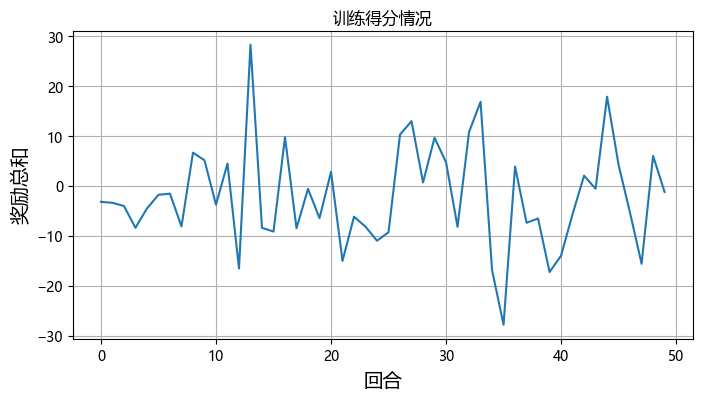

In [13]:
show_total_reward(rewards)